### Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud,STOPWORDS
import nltk
from transformers import pipeline
import torch
from emoji import demojize
from utils import data_cleaning

# Check PyTorch installation and available device
print(f"PyTorch version: {torch.__version__}")
print(f"MPS (Apple Metal) available: {torch.backends.mps.is_available()}")
print(f"CUDA available: {torch.cuda.is_available()}")

/Users/diegobolanos/.pyenv/versions/sentiment-analysis-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/diegobolanos/.pyenv/versions/sentiment-analysis-env/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


PyTorch version: 2.6.0
MPS (Apple Metal) available: True
CUDA available: False


/Users/diegobolanos/.pyenv/versions/sentiment-analysis-env/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### Data Loading

In [2]:
df = pd.read_csv('../data/data_collection/reddit_raw_posts.csv')
df.head()

,Title,Subreddit,Author,Likes,Comments
0,Texas Supreme Court Rules Against Woman Who So...,news,Lifeboatb,7231,912
1,Texas woman who sought court permission for ab...,news,11-110011,24560,2327
2,Home Alone star gets life-saving cancer surger...,news,ILikeTalkn2Myself,8341,499
3,Russian opposition leader Navalny missing from...,news,agnesiswitch,12825,742
4,Special counsel goes directly to Supreme Court...,news,hamsterberry,5294,484


In [3]:
# Customize stopword as per data
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words=set(stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegobolanos/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
slang_dict = {
    'btw': 'by the way',
    'lol': 'laughing out loud',
    'idk': 'I do not know',
    'imo': 'in my opinion',
    'imho': 'in my humble opinion',
    'brb': 'be right back',
    'tbh': 'to be honest',
    'lmao': 'laughing my ass off',
    'rofl': 'rolling on the floor laughing',
    'smh': 'shaking my head',
    'omg': 'oh my god',
    'ttyl': 'talk to you later',
    'afaik': 'as far as I know',
    'irl': 'in real life',
    'thx': 'thanks',
    'pls': 'please',
    'dm': 'direct message',
    'fyi': 'for your information',
    'b4': 'before',
    'gr8': 'great',
    'u': 'you',
    'r': 'are',
    'yolo': 'you only live once',
    'np': 'no problem',
    'g2g': 'got to go',
    'tldr': 'too long, didn\'t read',
    'jk': 'just kidding',
    'bff': 'best friends forever',
    'icymi': 'in case you missed it',
    'fomo': 'fear of missing out',
    'ftw': 'for the win',
    'wtf': 'what the f***',
    'nsfw': 'not safe for work',
    'nbd': 'no big deal',
    'faq': 'frequently asked questions',
    'afk': 'away from keyboard',
    'asap': 'as soon as possible',
    'won\'t': 'will not',
    'can\'t': 'can not',
    'don\'t': 'do not',
    'shouldn\'t': 'should not',
    'needn\'t': 'need not',
    'hasn\'t': 'has not',
    'haven\'t': 'have not',
    'weren\'t': 'were not',
    'mightn\'t': 'might not',
    'didn\'t': 'did not',
    'n\'t': 'not',
    '\'re': 'are',
    '\'s': 'is',
    '\'d': 'would',
    '\'ll': 'will',
    '\'t': 'not',
    '\'ve': 'have',
    '\'m': 'am'
}

In [5]:
def remove_stopwords(text: str) -> str:
    return ' '.join([word.strip() for word in text.lower().split() if word.strip().isalpha() and word.strip() not in stop_words])

df_cleaned = df.copy()
df_cleaned['Title'] = df_cleaned['Title'].apply(demojize)
df_cleaned['Title'] = df_cleaned['Title'].apply(remove_stopwords)

In [6]:
df_cleaned['Title_Cleaned'] = df_cleaned['Title'].apply(lambda x: data_cleaning(x, slang_dict))
print(f"Original:\n {df_cleaned['Title']}\n")
print(f"Processed:\n {df_cleaned['Title_Cleaned']}")

Original:
 0         texas supreme court rules woman sought abortion
1       texas woman sought court permission abortion l...
2       home alone star gets cancer surgery raised online
3       russian opposition leader navalny missing says...
4       special counsel goes directly supreme court re...
                              ...                        
5642                                   three accounts new
5643           market price rate cuts next year feds made
5644    good resources regarding industries businesses...
5645        cryptocurrencies greater fool theory steroids
5646      daily general discussion advice thread november
Name: Title, Length: 5647, dtype: object

Processed:
 0         texas supreme court rules woman sought abortion
1       texas woman sought court permission abortion l...
2       home alone star gets cancer surgery raised online
3       russian opposition leader navalny missing says...
4       special counsel goes directly supreme court re...
       

In [7]:
# Checking for missing values
df_cleaned.isna().sum()

Title             0
Subreddit         0
Author           23
Likes             0
Comments          0
Title_Cleaned     0
dtype: int64

In [8]:
df_cleaned['Title_Cleaned'].describe()

count     5647
unique    5491
top           
freq        21
Name: Title_Cleaned, dtype: object

### Exploratory Data Analysis

#### Visualization of Common Words from Post Title

In [9]:
# Initialize the classifier pipeline
sentiment_pipeline = pipeline('sentiment-analysis', model='finiteautomata/bertweet-base-sentiment-analysis')
sentences = df_cleaned['Title_Cleaned']

def annotate_sentiment(text):
    result = sentiment_pipeline(text)[0]
    return result['label']

# Annotate each post with a sentiment label
df_cleaned['Sentiment'] = df_cleaned['Title_Cleaned'].apply(annotate_sentiment)

annotated_file_path = '../data/data_collection/annotated_dataset.csv'
df_cleaned.to_csv(annotated_file_path, index=False)

/Users/diegobolanos/.pyenv/versions/sentiment-analysis-env/lib/python3.12/site-packages/huggingface_hub/file_download.py:795: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
# Load the annotated dataset
annotated_df = pd.read_csv(annotated_file_path)
annotated_df.head()

,Title,Subreddit,Author,Likes,Comments,Title_Cleaned,Sentiment
0,texas supreme court rules woman sought abortion,news,Lifeboatb,7231,912,texas supreme court rules woman sought abortion,NEU
1,texas woman sought court permission abortion l...,news,11-110011,24560,2327,texas woman sought court permission abortion l...,NEU
2,home alone star gets cancer surgery raised online,news,ILikeTalkn2Myself,8341,499,home alone star gets cancer surgery raised online,NEU
3,russian opposition leader navalny missing says...,news,agnesiswitch,12825,742,russian opposition leader navalny missing says...,NEG
4,special counsel goes directly supreme court re...,news,hamsterberry,5294,484,special counsel goes directly supreme court re...,NEU


In [11]:
# Check for missing values
missing_values = annotated_df['Title_Cleaned'].isna().sum()
print(f"Missing values: {missing_values}")

# Drop missing values
annotated_df.dropna(inplace=True)

Missing values: 21


### Basic Statistic of Posts Sentiment

Sentiment
NEG    1243
NEU    3448
POS     912
dtype: int64


<Axes: >

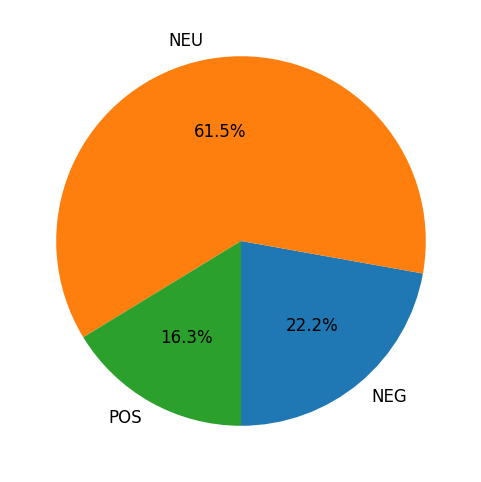

In [ ]:
# Let's count the number of posts by sentiments
sentiment_counts = annotated_df.groupby(['Sentiment']).size()
print(sentiment_counts)

# Let's visualize the sentiments
fig = plt.figure(figsize=(6,6), dpi=100)
ax = plt.subplot(111)
sentiment_counts.plot.pie(ax=ax, autopct='%1.1f%%', startangle=270, fontsize=12, label="")

### Word Cloud

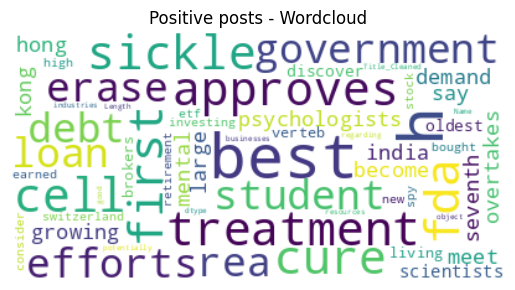

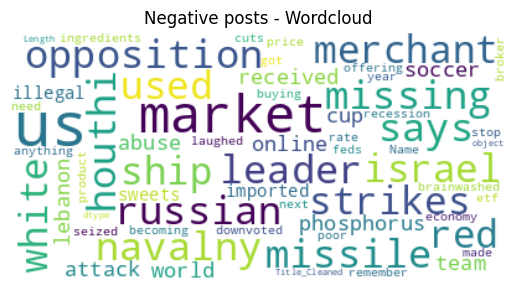

In [ ]:
# Wordcloud with positive posts
positive_posts = annotated_df['Title_Cleaned'][annotated_df["Sentiment"] == 'POS']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
positive_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(positive_posts))
plt.figure()
plt.title("Positive posts - Wordcloud")
plt.imshow(positive_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()
 
# Wordcloud with negative posts
negative_posts = annotated_df['Title_Cleaned'][annotated_df["Sentiment"] == 'NEG']
stop_words = ["https", "co", "RT"] + list(STOPWORDS)
negative_wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white", stopwords = stop_words).generate(str(negative_posts))
plt.figure()
plt.title("Negative posts - Wordcloud")
plt.imshow(negative_wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()


### Count Vectorizer Analysis

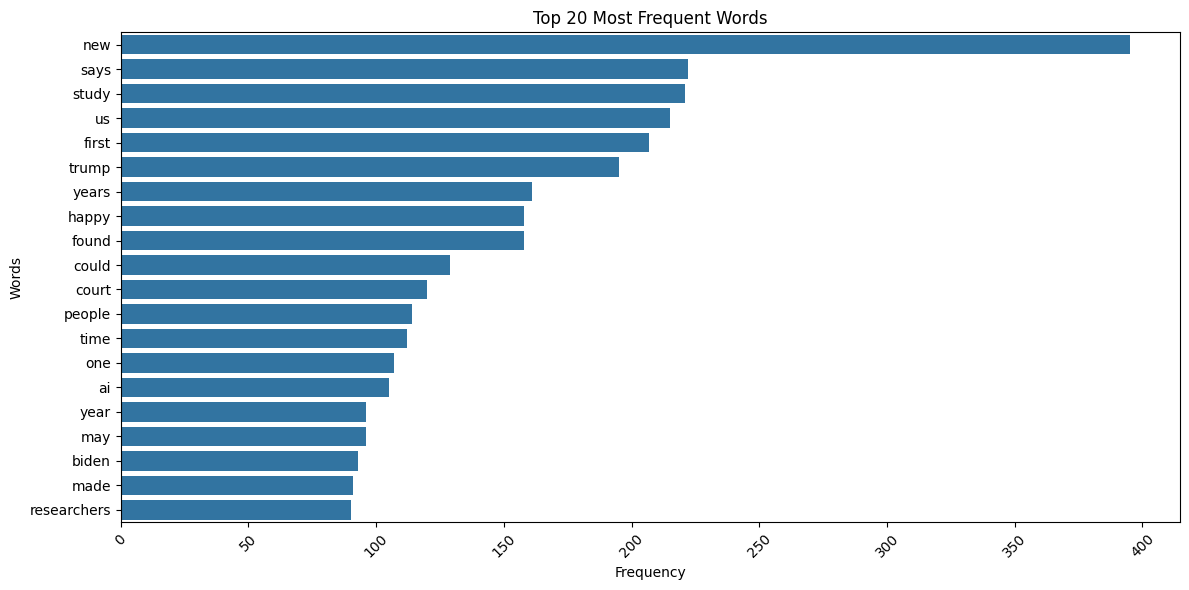

In [13]:
# Create and fit the Count Vectorizer
vectorizer = CountVectorizer(max_features=100)
text_matrix = vectorizer.fit_transform(annotated_df['Title_Cleaned'])

# Get word frequencies
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': text_matrix.sum(axis=0).A1
})
word_freq = word_freq.sort_values('frequency', ascending=False)

# Plot top 20 most frequent words
plt.figure(figsize=(12, 6))
sns.barplot(data=word_freq.head(20), x='frequency', y='word')
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

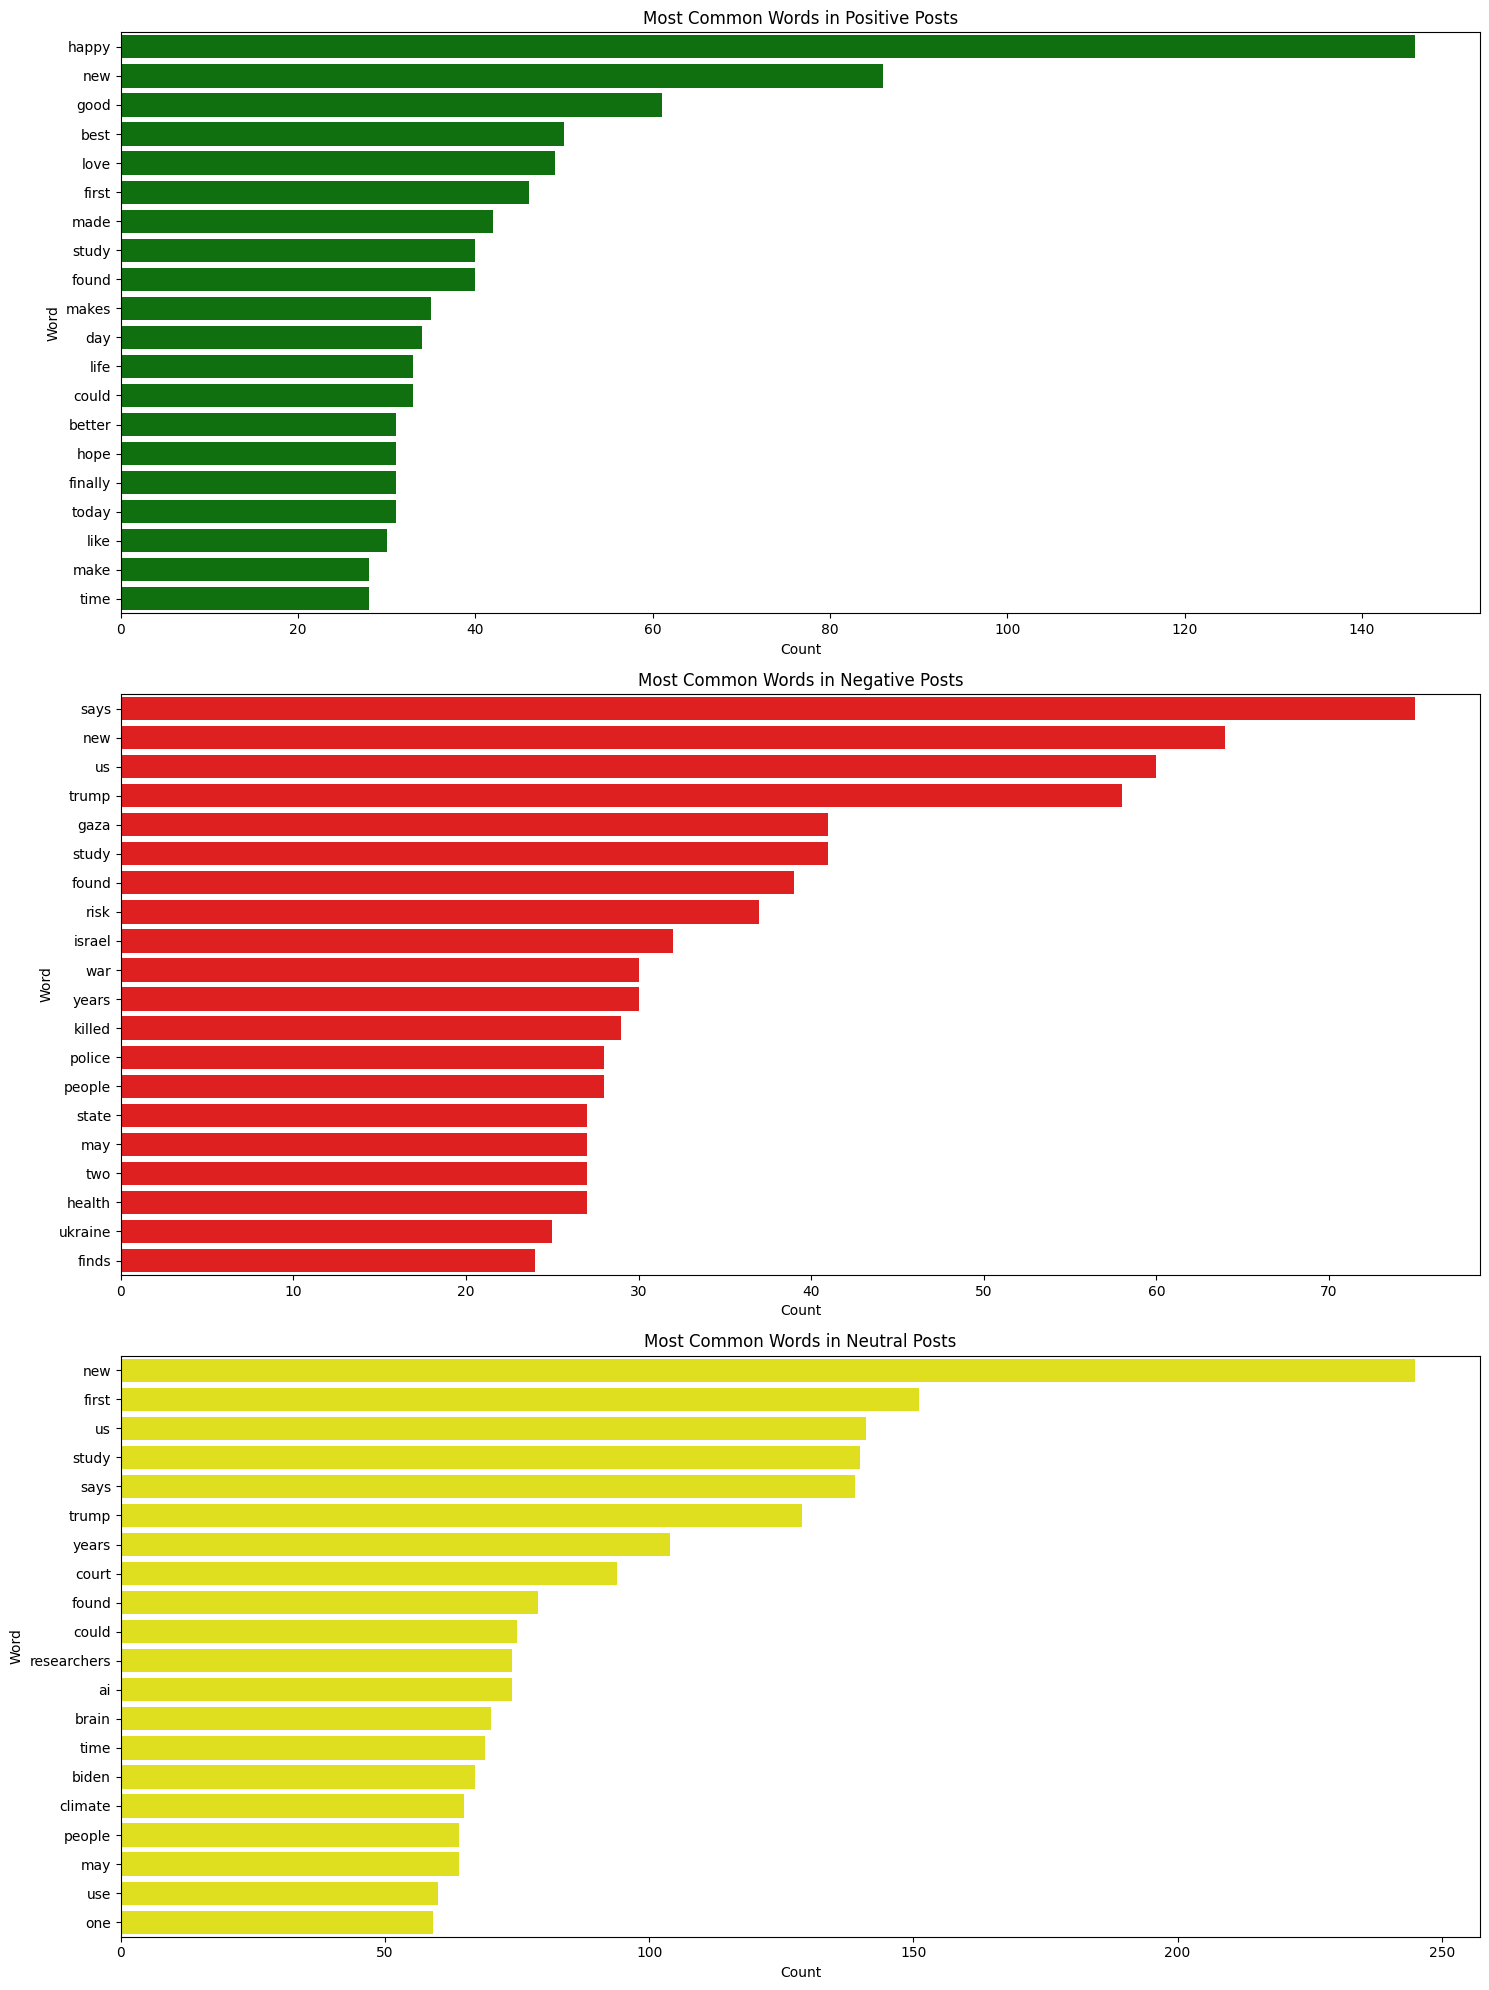

In [14]:
# Get word frequencies for each sentiment
positive_words = ' '.join(annotated_df[annotated_df['Sentiment'] == 'POS']['Title_Cleaned'])
negative_words = ' '.join(annotated_df[annotated_df['Sentiment'] == 'NEG']['Title_Cleaned'])
neutral_words = ' '.join(annotated_df[annotated_df['Sentiment'] == 'NEU']['Title_Cleaned'])

# Create separate vectorizers for each sentiment
vectorizer = CountVectorizer(max_features=20)

# Transform and create DataFrames
pos_freq = pd.DataFrame({
    'Word': vectorizer.fit(positive_words.split()).get_feature_names_out(),
    'Count': vectorizer.transform([positive_words]).toarray().sum(axis=0)
}).sort_values('Count', ascending=False)

neg_freq = pd.DataFrame({
    'Word': vectorizer.fit(negative_words.split()).get_feature_names_out(),
    'Count': vectorizer.transform([negative_words]).toarray().sum(axis=0)
}).sort_values('Count', ascending=False)

neu_freq = pd.DataFrame({
    'Word': vectorizer.fit(neutral_words.split()).get_feature_names_out(),
    'Count': vectorizer.transform([neutral_words]).toarray().sum(axis=0)
}).sort_values('Count', ascending=False)

# Create bar plots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 20))

# Plot positive words
sns.barplot(data=pos_freq, x='Count', y='Word', color='green', ax=ax1)
ax1.set_title('Most Common Words in Positive Posts')

# Plot negative words
sns.barplot(data=neg_freq, x='Count', y='Word', color='red', ax=ax2)
ax2.set_title('Most Common Words in Negative Posts')

# Plot neutral words
sns.barplot(data=neu_freq, x='Count', y='Word', color='yellow', ax=ax3)
ax3.set_title('Most Common Words in Neutral Posts')

plt.tight_layout()
plt.show()

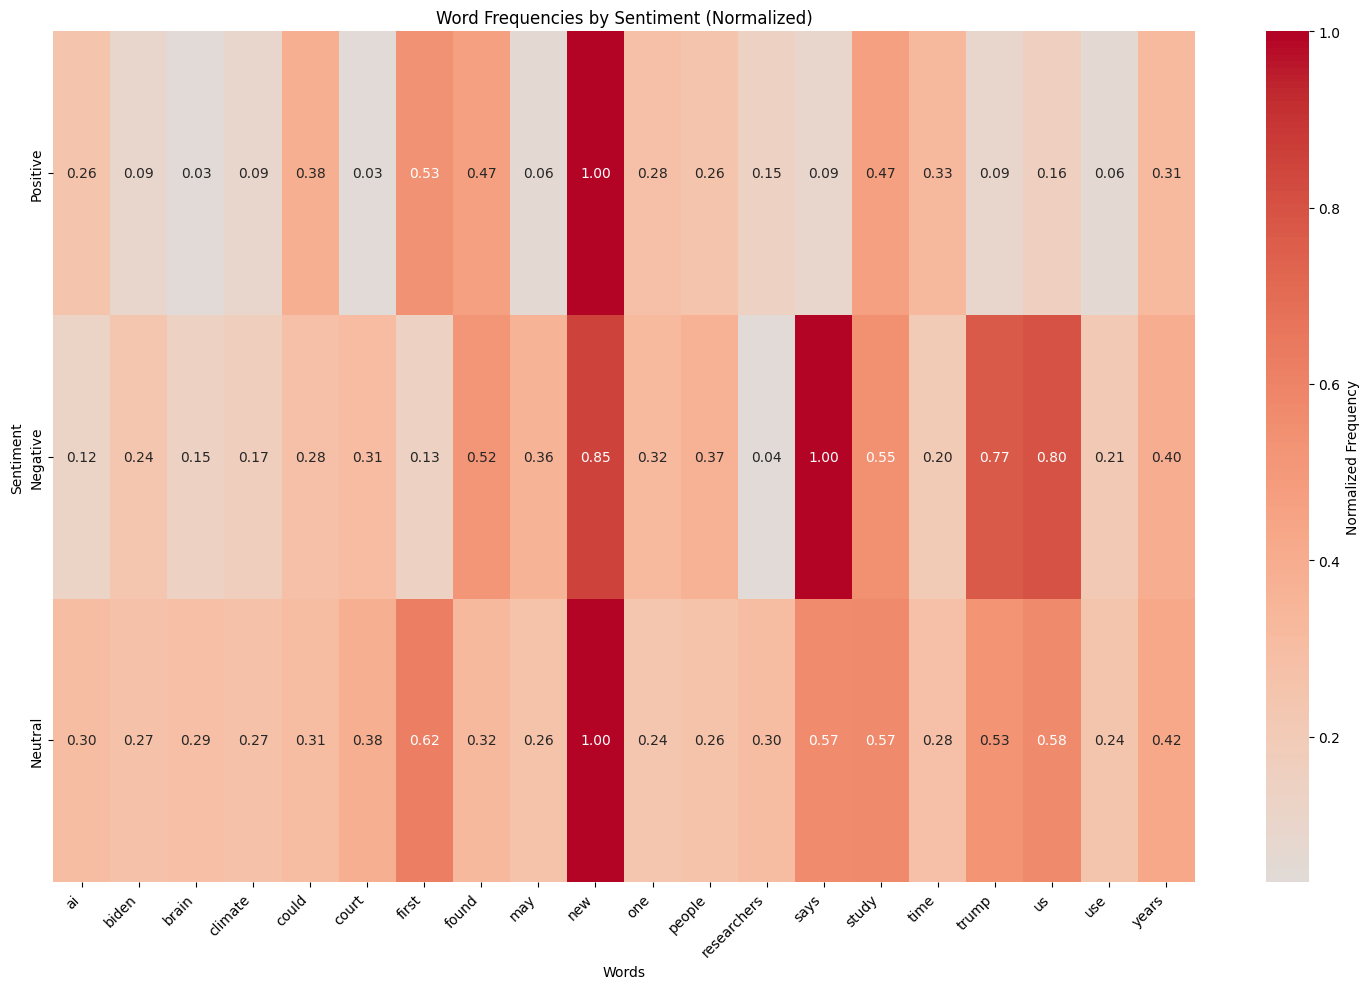

In [15]:
sentiment_df = pd.DataFrame({
    'Positive': vectorizer.transform([positive_words]).toarray().sum(axis=0),
    'Negative': vectorizer.transform([negative_words]).toarray().sum(axis=0),
    'Neutral': vectorizer.transform([neutral_words]).toarray().sum(axis=0)
}, index=vectorizer.get_feature_names_out())

# Normalize the values for better visualization
sentiment_df_normalized = sentiment_df.apply(lambda x: x/x.max(), axis=0)

# Plot heatmap
plt.figure(figsize=(15, 10))
sns.heatmap(sentiment_df_normalized.T, 
            cmap='coolwarm',
            center=0,
            annot=True,
            fmt='.2f',
            cbar_kws={'label': 'Normalized Frequency'},
            xticklabels=True,
            yticklabels=True)

plt.title('Word Frequencies by Sentiment (Normalized)')
plt.xlabel('Words')
plt.ylabel('Sentiment')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()